In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
colab_path = '/content/drive/MyDrive/ColabNotebooks/airplane'

In [4]:
import pandas as pd
import numpy as np
import random
import os
import gc
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [6]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [7]:
csv_to_parquet(colab_path + '/train.csv', 'train')
csv_to_parquet(colab_path + '/test.csv', 'test')

train Done.
test Done.


In [220]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv(colab_path + '/sample_submission.csv', index_col = 0)

##**데이터 파악하기**

In [ ]:
train.shape # 데이터셋의 형태를 확인

(1000000, 19)

In [ ]:
train.info() # 컬럼명, 데이터타입을 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [ ]:
train.describe() #데이터셋의 수치형 컬럼별 주요 통계량을 summary

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


In [ ]:
train.isnull().sum() #결측값 확인

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
#각 열별 결측치의 비율
print(train.isnull().sum()/len(train) * 100)

ID                           0.0000
Month                        0.0000
Day_of_Month                 0.0000
Estimated_Departure_Time    10.9019
Estimated_Arrival_Time      10.9040
Cancelled                    0.0000
Diverted                     0.0000
Origin_Airport               0.0000
Origin_Airport_ID            0.0000
Origin_State                10.9015
Destination_Airport          0.0000
Destination_Airport_ID       0.0000
Destination_State           10.9079
Distance                     0.0000
Airline                     10.8920
Carrier_Code(IATA)          10.8990
Carrier_ID(DOT)             10.8997
Tail_Number                  0.0000
Delay                       74.4999
dtype: float64


In [22]:
train1 = train.dropna() #결측치를 제거

<Axes: xlabel='Month', ylabel='count'>

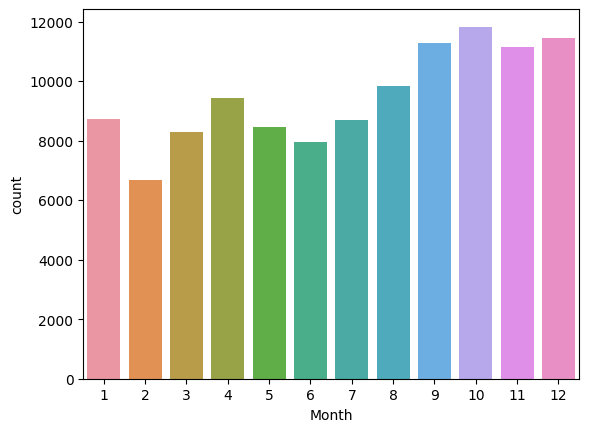

In [32]:
sns.countplot(x = 'Month', data = train1) #월별 항공편

<Axes: xlabel='Day_of_Month', ylabel='count'>

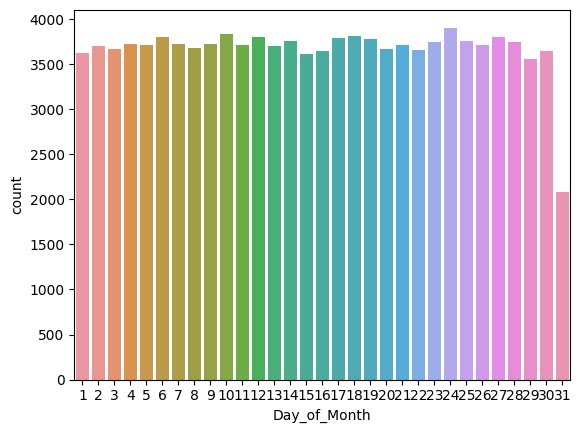

In [33]:
sns.countplot(x = 'Day_of_Month', data = train1) #일별 항공편

<Axes: xlabel='Day_of_Month', ylabel='count'>

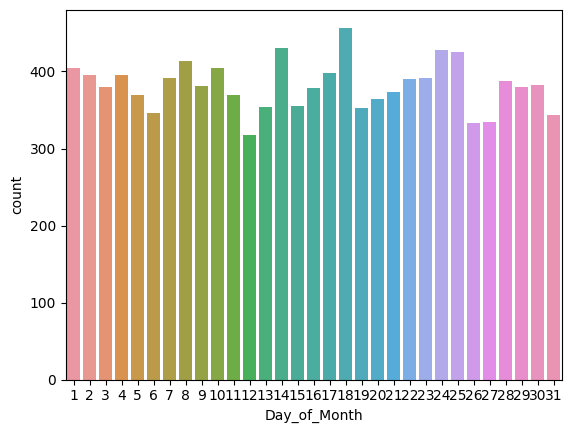

In [108]:
tr1 = train1[train1['Month']==10] #10월 추출
sns.countplot(x = 'Day_of_Month', data = tr1) #10월의 일별 항공편

In [134]:
tr11= train1['Delay'].value_counts().reset_index()
tr11

,index,Delay
0,Not_Delayed,93848
1,Delayed,19939


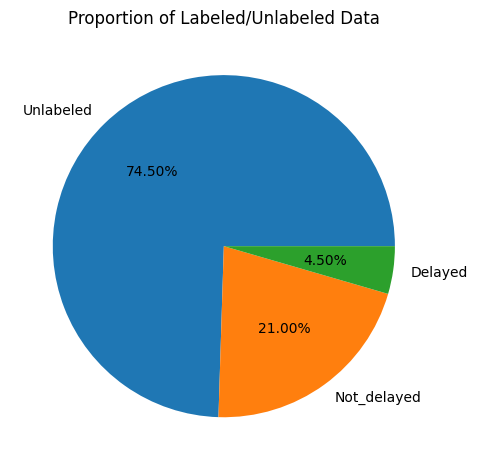

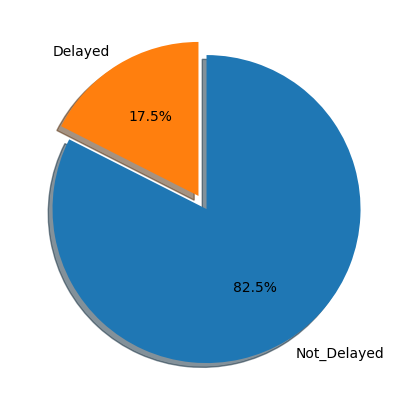

In [201]:
unlabeled_delay_value = train.Delay.isnull().sum()

not_delay_value = train.loc[train.Delay == 'Not_Delayed'].shape[0]
delay_value = train.loc[train.Delay == 'Delayed'].shape[0]

labels = ['Unlabeled', 'Not_delayed', 'Delayed']
sizes = [unlabeled_delay_value, not_delay_value, delay_value]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.set_title('Proportion of Labeled/Unlabeled Data')
plt.tight_layout()

explode = [0.05] * 2

plt.figure(figsize = (10, 5))
plt.pie(tr11['Delay'], labels = tr11['index'], autopct = '%.1f%%', startangle = 90, counterclock = False,shadow = True, explode = explode)
plt.show()



In [232]:
#레이블(Delay)을 제외한 결측값이 존재하는 변수들을 제거
NaN_col = ['Origin_State','Destination_State','Airline','Estimated_Departure_Time', 'Estimated_Arrival_Time','Carrier_Code(IATA)','Carrier_ID(DOT)']

train.dropna(subset=NaN_col, inplace=True)
test.dropna(subset=NaN_col, inplace=True)

print('Done.')

Done.


In [234]:
train.isnull().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time         0
Estimated_Arrival_Time           0
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                     0
Destination_Airport              0
Destination_Airport_ID           0
Destination_State                0
Distance                         0
Airline                          0
Carrier_Code(IATA)               0
Carrier_ID(DOT)                  0
Tail_Number                      0
Delay                       744999
dtype: int64

In [235]:
#질적 변수들을 수치화합니다
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])
print('Done.')

Done.


In [236]:
traind = train.drop(['Cancelled','Diverted'], axis=1) #의미없는 열 제거
testd = test.drop(['Cancelled','Diverted'], axis=1) #의미없는 열 제거

In [237]:
train_x = traind.drop(columns=['ID'])
#train_y = train['Delay']
test_x = testd.drop(columns=['ID'])

In [238]:
# 레이블이 있는 데이터와 없는 데이터로 분리
labeled_data = train_x[train_x['Delay'].notna()]
unlabeled_data = train_x[train_x['Delay'].isna()]

In [239]:
# 레이블이 있는 데이터로 모델 학습
X_train, X_test, y_train, y_test = train_test_split(
    labeled_data.drop(columns=['Delay']),
    labeled_data['Delay'],
    test_size=0.3,
    random_state=42
)

In [240]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [241]:
# 레이블이 없는 데이터 예측
unlabeled_data['Delay'] = model.predict(unlabeled_data.drop(columns=['Delay']))

<ipython-input-241-ab8b4ee71d8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_data['Delay'] = model.predict(unlabeled_data.drop(columns=['Delay']))


In [242]:
merged_train = pd.concat([labeled_data, unlabeled_data], axis=0) #merge

In [243]:
merged_train['Delay'] = merged_train['Delay'].replace({'Not_Delayed': 0, 'Delayed': 1})

In [244]:
merged_train['Delay'].value_counts()

0    941791
1     58209
Name: Delay, dtype: int64

In [245]:
train_x = merged_train.drop(columns=['Delay'])
train_y = merged_train['Delay']
test_x = test.drop(columns=['ID'])

In [246]:
model = XGBClassifier(
    learning_rate =0.1,
    n_estimators=300,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

In [ ]:
# 모델 학습
model.fit(train_x, train_y)

In [ ]:
y_pred = model.predict_proba(test_x)


In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)


In [ ]:
submission.to_csv('XGB7_submission.csv', index=True)

In [157]:
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train.loc[:, 'Delay_num'] = train['Delay'].apply(lambda x: to_number(x, column_number))
print('Done.')

Done.


In [158]:
train_x = traind.drop(columns=['ID', 'Delay', 'Delay_num'])
train_y = traind['Delay_num']
test_x = test.drop(columns=['ID'])

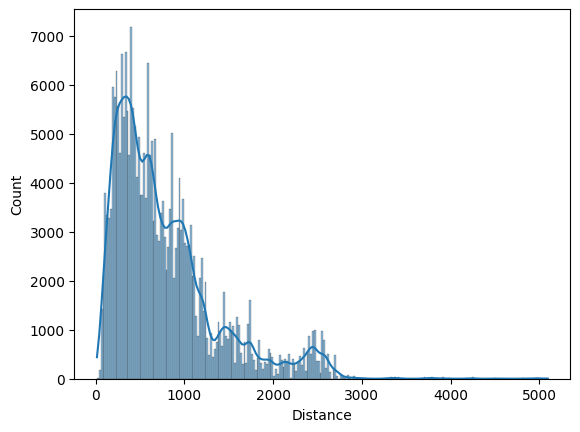

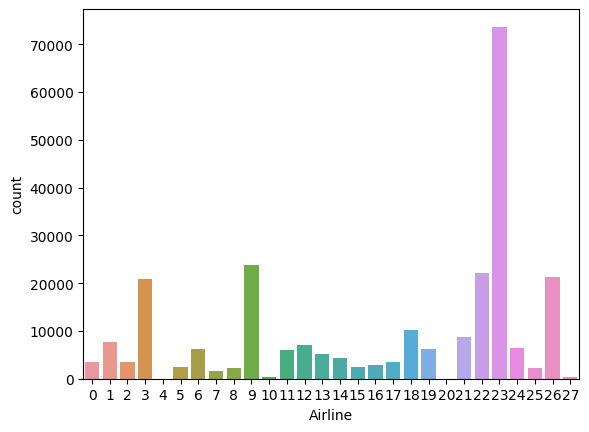

In [160]:
# 변수별 분포 확인
sns.histplot(traind['Distance'], kde=True)
plt.show()

sns.countplot(x='Airline', data=traind)
plt.show()

In [78]:
# 각 열의 고유값의 수
train.nunique()

ID                          1000000
Month                            12
Day_of_Month                     31
Estimated_Departure_Time       1365
Estimated_Arrival_Time         1428
Cancelled                         1
Diverted                          1
Origin_Airport                  374
Origin_Airport_ID               374
Origin_State                     52
Destination_Airport             375
Destination_Airport_ID          375
Destination_State                52
Distance                       1597
Airline                          28
Carrier_Code(IATA)               11
Carrier_ID(DOT)                  28
Tail_Number                    6430
Delay                             2
dtype: int64

In [79]:
train['Destination_State'].value_counts() # 특정 열의 값 개수, 디폴트  내림차순

California                                        104347
Texas                                              87950
Florida                                            66474
Illinois                                           58323
New York                                           44144
Georgia                                            41620
Colorado                                           39490
North Carolina                                     35089
Virginia                                           34272
Washington                                         25666
Nevada                                             23661
Pennsylvania                                       23660
Michigan                                           22452
Arizona                                            22448
New Jersey                                         21910
Massachusetts                                      18189
Missouri                                           17212
Minnesota                      

In [99]:
#train.corr()  상관계수, 문자열 제외
print(train[['Estimated_Departure_Time','Estimated_Arrival_Time','Distance']].corr()) #세 변수 지정 상관계수

                          Estimated_Departure_Time  Estimated_Arrival_Time  \
Estimated_Departure_Time                  1.000000                0.683152   
Estimated_Arrival_Time                    0.683152                1.000000   
Distance                                 -0.010714                0.013754   

                          Distance  
Estimated_Departure_Time -0.010714  
Estimated_Arrival_Time    0.013754  
Distance                  1.000000  


<Axes: >

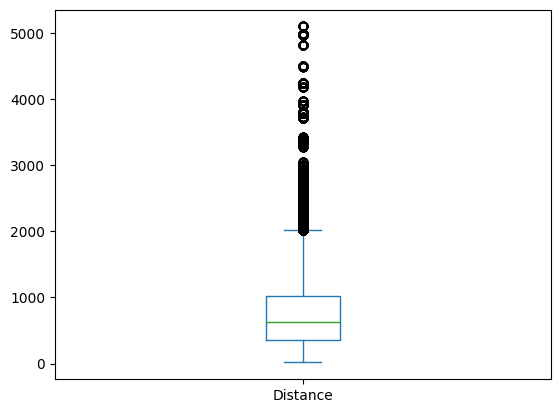

In [30]:
train['Distance'].plot(kind='box') #box-plot

<ipython-input-162-940b5b2a9940>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(traind.corr(), annot = True, cmap = 'Blues')


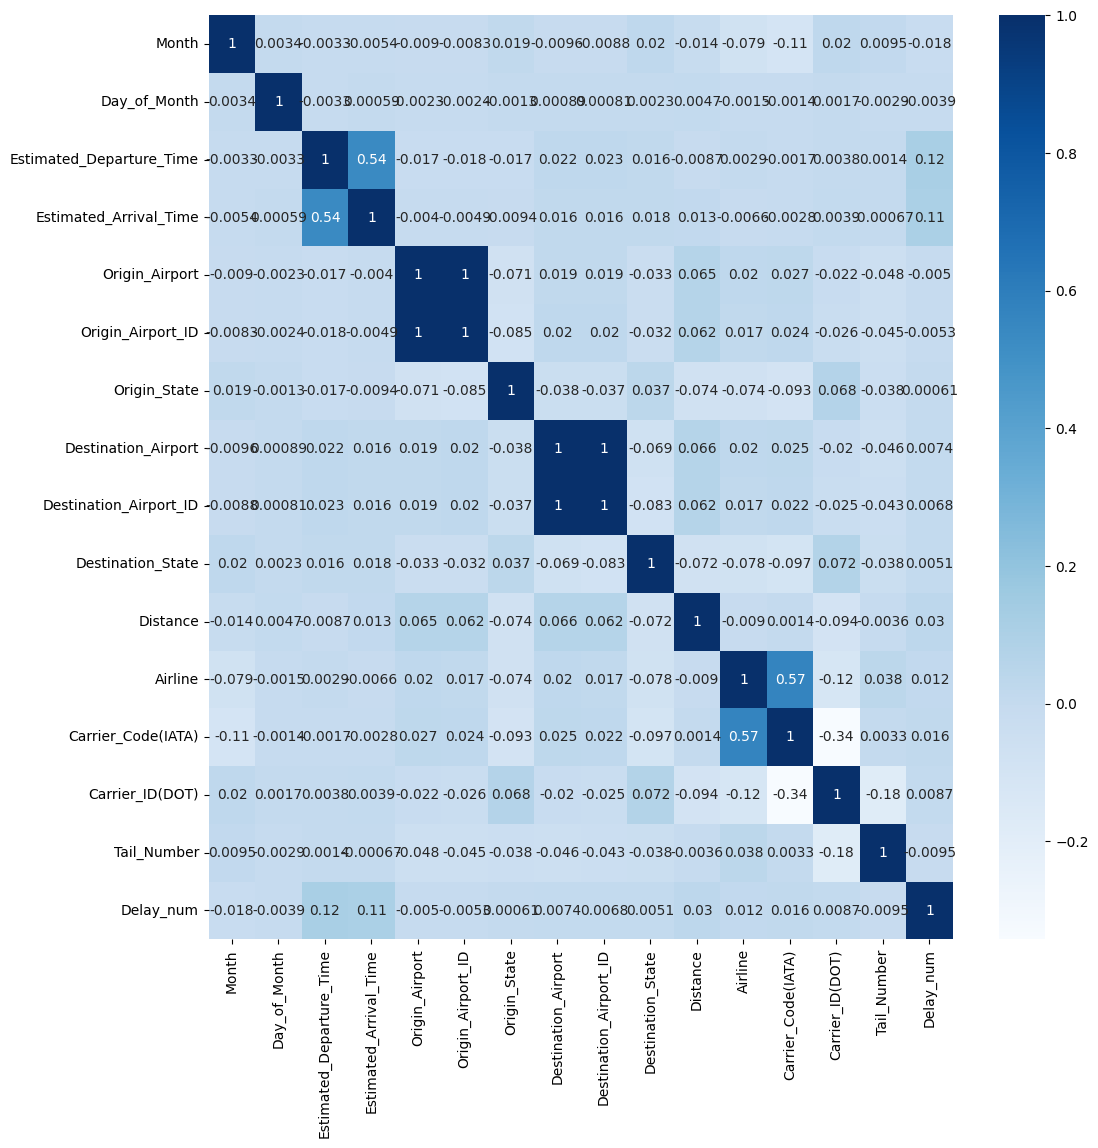

In [162]:
# 히트맵으로 상관관계 표시
plt.figure(figsize = (12,12))
sns.heatmap(traind.corr(), annot = True, cmap = 'Blues')
plt.show()